# EMAIL SPAM DETECTION WITH MACHINE LEARNING



The code implements an email spam detection system using machine learning. It loads email data from a CSV file, preprocesses the data, and then trains a logistic regression classifier to distinguish between spam and ham emails.

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import nltk
from nltk.corpus import stopwords
from collections import Counter

# Libraries for visualisation

import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Download the stopwords dataset

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Read the CSV file containing email data into a DataFrame

df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv",encoding='latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
# Drop unnecessary columns from the DataFrame

columns_to_drop = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"]
df.drop(columns=columns_to_drop, inplace=True)

In [6]:
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
# Rename the columns "v1 and "v2" to new names

new_column_names = {"v1":"Category","v2":"Message"}
df.rename(columns = new_column_names,inplace = True)

In [8]:
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [9]:
# Replace any NaN values in the DataFrame with a space

data = df.where((pd.notnull(df)), ' ')

In [10]:
data.head(10)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [11]:
data.describe()

,Category,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [13]:
data.shape

(5572, 2)

In [14]:
# Convert the "Category" column values to numerical representation (0 for "spam" and 1 for "ham")

data.loc[data["Category"] == "spam", "Category"] = 0
data.loc[data["Category"] == "ham", "Category"] = 1


In [15]:
# Separate the feature (message) and target (category) data

X = data["Message"]
Y = data["Category"]

In [16]:
print(X)

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: Message, Length: 5572, dtype: object


In [17]:
print(Y)

0       1
1       1
2       0
3       1
4       1
       ..
5567    0
5568    1
5569    1
5570    1
5571    1
Name: Category, Length: 5572, dtype: object


In [18]:
# Split the data into training and testing sets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 3)

In [19]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(5572,)
(4457,)
(1115,)


In [20]:
print(Y.shape)
print(Y_train.shape)
print(Y_test.shape)

(5572,)
(4457,)
(1115,)


In [21]:
# Create a TF-IDF vectorizer to convert text messages into numerical features

feature_extraction = TfidfVectorizer(min_df=1, stop_words="english", lowercase=True)

In [22]:
# Convert the training and testing text messages into numerical features using TF-IDF

X_train_features = feature_extraction.fit_transform(X_train)
X_test_features = feature_extraction.transform(X_test)


In [23]:
# Convert the target values to integers (0 and 1)

Y_train = Y_train.astype("int")
Y_test = Y_test.astype("int")

In [24]:
print(X_train)

3075    Mum, hope you are having a great day. Hoping t...
1787                           Yes:)sura in sun tv.:)lol.
1614    Me sef dey laugh you. Meanwhile how's my darli...
4304                Yo come over carlos will be here soon
3266                    Ok then i come n pick u at engin?
                              ...                        
789                          Gud mrng dear hav a nice day
968             Are you willing to go for aptitude class.
1667    So now my dad is gonna call after he gets out ...
3321    Ok darlin i supose it was ok i just worry too ...
1688                     Nan sonathaya soladha. Why boss?
Name: Message, Length: 4457, dtype: object


In [25]:
print(X_train_features)

  (0, 741)	0.3219352588930141
  (0, 3979)	0.2410582143632299
  (0, 4296)	0.3891385935794867
  (0, 6599)	0.20296878731699391
  (0, 3386)	0.3219352588930141
  (0, 2122)	0.38613577623520473
  (0, 3136)	0.440116181574609
  (0, 3262)	0.25877035357606315
  (0, 3380)	0.21807195185332803
  (0, 4513)	0.2909649098524696
  (1, 4061)	0.380431198316959
  (1, 6872)	0.4306015894277422
  (1, 6417)	0.4769136859540388
  (1, 6442)	0.5652509076654626
  (1, 7443)	0.35056971070320353
  (2, 933)	0.4917598465723273
  (2, 2109)	0.42972812260098503
  (2, 3917)	0.40088501350982736
  (2, 2226)	0.413484525934624
  (2, 5825)	0.4917598465723273
  (3, 6140)	0.4903863168693604
  (3, 1599)	0.5927091854194291
  (3, 1842)	0.3708680641487708
  (3, 7453)	0.5202633571003087
  (4, 2531)	0.7419319091456392
  :	:
  (4452, 2122)	0.31002103760284144
  (4453, 999)	0.6760129013031282
  (4453, 7273)	0.5787739591782677
  (4453, 1762)	0.45610005640082985
  (4454, 3029)	0.42618909997886
  (4454, 2086)	0.3809693742808703
  (4454, 3088)

In [26]:
# Create a logistic regression model and train it on the training data

model = LogisticRegression()
model.fit(X_train_features, Y_train)

LogisticRegression()

In [27]:
# Make predictions on the training data and calculate the accuracy

prediction_on_training_data = model.predict(X_train_features)
accuracy_on_training_data = accuracy_score(Y_train, prediction_on_training_data)

In [28]:
print("Accuracy on training data:",accuracy_on_training_data)

Accuracy on training data: 0.9661207089970832


In [29]:
# Make predictions on the test data and calculate the accuracy

prediction_on_test_data = model.predict(X_test_features)
accuracy_on_test_data = accuracy_score(Y_test,prediction_on_test_data)

In [30]:
print("Accuracy on test data:",accuracy_on_test_data)

Accuracy on test data: 0.9623318385650225


In [31]:
# Test the model with some custom email messages

input_your_mail = ["Congratulations! You have won a free vacation to an exotic destination. Click the link to claim your prize now!"]
input_data_features = feature_extraction.transform(input_your_mail)
prediction = model.predict(input_data_features)
print(prediction)


# Print the prediction result

if (prediction)[0] == 1:
  print("Ham Mail")
else:
  print("Spam Mail")

[0]
Spam Mail


In [32]:
# Test the model with some custom email messages

input_your_mail = ["Meeting reminder: Tomorrow, 10 AM, conference room. See you there!"]
input_data_features = feature_extraction.transform(input_your_mail)
prediction = model.predict(input_data_features)
print(prediction)


# Print the prediction result

if (prediction)[0] == 1:
  print("Ham Mail")
else:
  print("Spam Mail")


[1]
Ham Mail


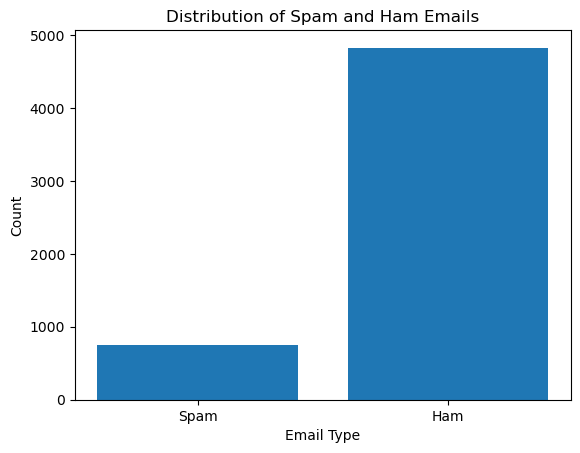

In [33]:
# Data visualization - Distribution of Spam and Ham Emails

spam_count = data[data['Category'] == 0].shape[0]
ham_count = data[data['Category'] == 1].shape[0]

plt.bar(['Spam', 'Ham'], [spam_count, ham_count])
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.title('Distribution of Spam and Ham Emails')
plt.show()

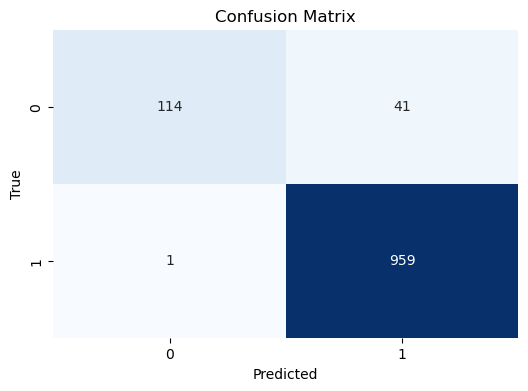

In [34]:
# Data visualization - Confusion Matrix

cm = confusion_matrix(Y_test, prediction_on_test_data)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


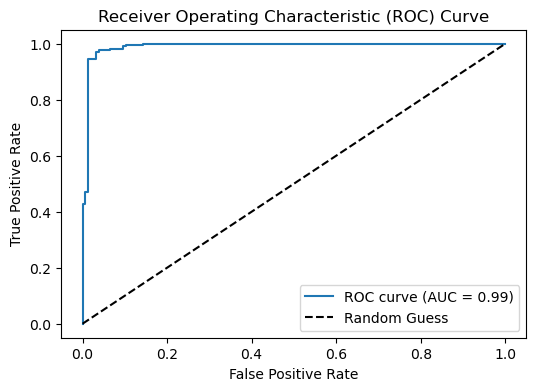

In [35]:
# Data visualization - ROC Curve

probabilities = model.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, probabilities)
roc_auc = roc_auc_score(Y_test, probabilities)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


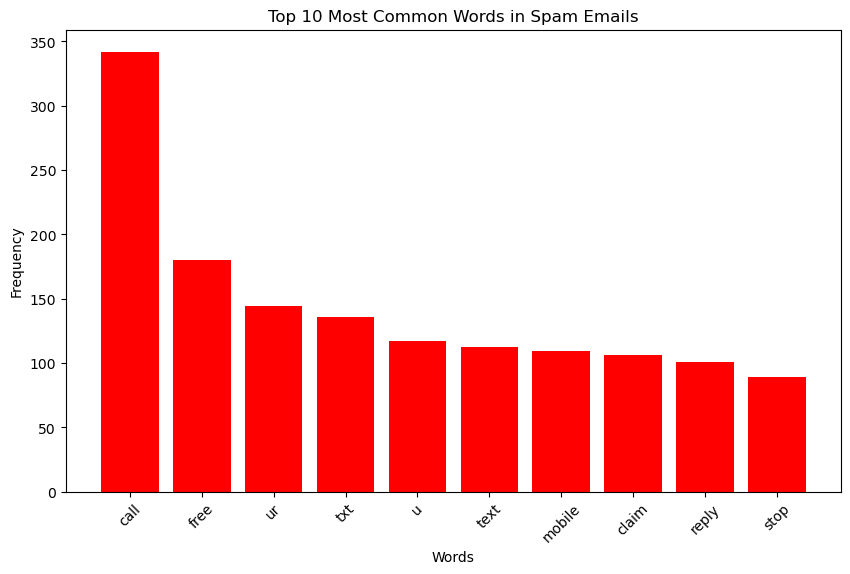

In [36]:
# Data visualization - Top 10 Most Common Words in Spam Emails

stop_words = set(stopwords.words('english'))
spam_words = " ".join(data[data['Category'] == 0]['Message']).split()
ham_words = " ".join(data[data['Category'] == 1]['Message']).split()

spam_word_freq = Counter([word.lower() for word in spam_words if word.lower() not in stop_words and word.isalpha()])

plt.figure(figsize=(10, 6))
plt.bar(*zip(*spam_word_freq.most_common(10)), color='r')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words in Spam Emails')
plt.xticks(rotation=45)
plt.show()

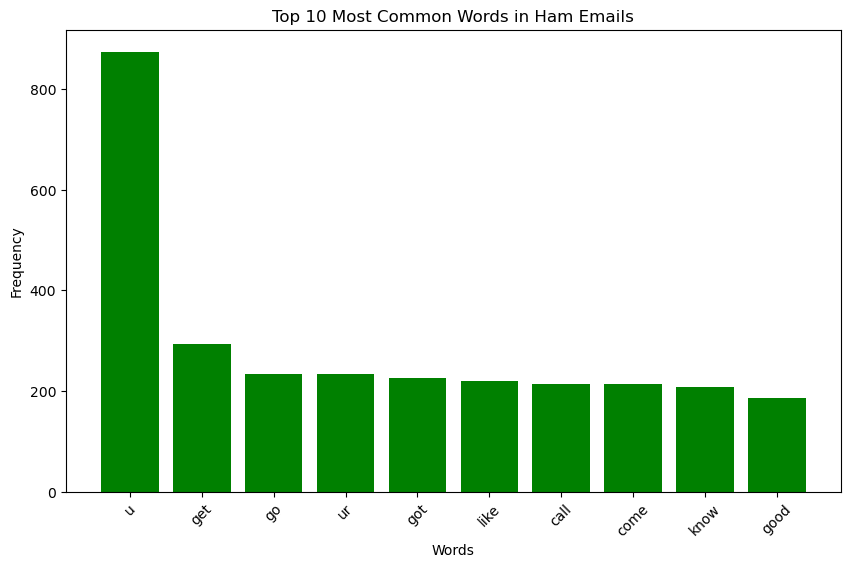

In [37]:
# Data visualization - Top 10 Most Common Words in Ham Emails

ham_word_freq = Counter([word.lower() for word in ham_words if word.lower() not in stop_words and word.isalpha()])

plt.figure(figsize=(10, 6))
plt.bar(*zip(*ham_word_freq.most_common(10)), color='g')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words in Ham Emails')
plt.xticks(rotation=45)
plt.show()